In [1]:
url = 'https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz

--2022-06-12 10:04:55--  https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2753340328 (2.6G) [application/x-gzip]
Saving to: ‘fgvc-aircraft-2013b.tar.gz’

fgvc-aircraft-2013b 100%[===================>]   2.56G  36.1MB/s    in 74s     

2022-06-12 10:06:10 (35.3 MB/s) - ‘fgvc-aircraft-2013b.tar.gz’ saved [2753340328/2753340328]



In [ ]:
# !mv /content/fgvc-aircraft-2013b.tar.gz drive/MyDrive/fptAI/

In [3]:
!tar --gunzip --extract --file /content/fgvc-aircraft-2013b.tar.gz

### Crop image

In [4]:
import os
os.mkdir('cropped_images')

In [5]:
"""data/images_box.txt contains the aircraft bounding boxes, one per image. 
The bounding box is specified by four numbers: xmin, ymin, xmax and ymax. 
The top-left pixel of an image has coordinate (1,1)."""
import numpy as np
from PIL import Image 


path_img_folder = '/content/fgvc-aircraft-2013b/data/images/'
path_img_box = '/content/fgvc-aircraft-2013b/data/images_box.txt'

f = open(path_img_box, "r")
for img_box in f.readlines():
  img_name = img_box.split()[0]
  xmin, ymin, xmax, ymax = [int(coor) for coor in img_box.split()[1:]]
  path_img = path_img_folder+img_name+'.jpg'
  
  img = Image.open(path_img)
  img = img.crop((xmin,ymin,xmax,ymax))

  img.save('cropped_images/' +img_name + '.jpg')

### Dataset

In [14]:
from torch.utils.data import Dataset,DataLoader, random_split, sampler
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import torchvision
from torchvision import models, datasets
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [7]:
label2index = {}
for i,label in enumerate(open('/content/fgvc-aircraft-2013b/data/variants.txt').readlines()):
  label2index[label[:-1].replace(' ','-')] = i #cutoff \n in the end

print(label2index)
print(len(label2index))

class AircraftDataset(Dataset):
  def __init__(self, file, root_dir, transform = None):
    self.annotations = open(file, "r").readlines()
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    obj = self.annotations[index].split()
    img_path = self.root_dir + obj[0] + '.jpg'

    image = plt.imread(img_path)

    y_label = obj[1:]
    y_label = '-'.join(y_label)
    y_label = torch.tensor(label2index[y_label])

    if self.transform:
        image = self.transform(image)

    return (image, y_label)


{'707-320': 0, '727-200': 1, '737-200': 2, '737-300': 3, '737-400': 4, '737-500': 5, '737-600': 6, '737-700': 7, '737-800': 8, '737-900': 9, '747-100': 10, '747-200': 11, '747-300': 12, '747-400': 13, '757-200': 14, '757-300': 15, '767-200': 16, '767-300': 17, '767-400': 18, '777-200': 19, '777-300': 20, 'A300B4': 21, 'A310': 22, 'A318': 23, 'A319': 24, 'A320': 25, 'A321': 26, 'A330-200': 27, 'A330-300': 28, 'A340-200': 29, 'A340-300': 30, 'A340-500': 31, 'A340-600': 32, 'A380': 33, 'ATR-42': 34, 'ATR-72': 35, 'An-12': 36, 'BAE-146-200': 37, 'BAE-146-300': 38, 'BAE-125': 39, 'Beechcraft-1900': 40, 'Boeing-717': 41, 'C-130': 42, 'C-47': 43, 'CRJ-200': 44, 'CRJ-700': 45, 'CRJ-900': 46, 'Cessna-172': 47, 'Cessna-208': 48, 'Cessna-525': 49, 'Cessna-560': 50, 'Challenger-600': 51, 'DC-10': 52, 'DC-3': 53, 'DC-6': 54, 'DC-8': 55, 'DC-9-30': 56, 'DH-82': 57, 'DHC-1': 58, 'DHC-6': 59, 'DHC-8-100': 60, 'DHC-8-300': 61, 'DR-400': 62, 'Dornier-328': 63, 'E-170': 64, 'E-190': 65, 'E-195': 66, 'EMB

In [8]:
root_dir = '/content/cropped_images/'
train_path = "/content/fgvc-aircraft-2013b/data/images_variant_trainval.txt"
test_path = "/content/fgvc-aircraft-2013b/data/images_variant_test.txt"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
image_size = 224

In [9]:
image_transforms = { 
    'train':torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(size=(224, 224)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomGrayscale(0.5),
            torchvision.transforms.RandomAutocontrast(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
    ]),
    'test':torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(size=(224,224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
        ])
}

In [10]:
train_dataset = AircraftDataset(file = train_path,root_dir = root_dir, transform = image_transforms['train'])
test_dataset = AircraftDataset(file = test_path,root_dir = root_dir, transform = image_transforms['test'])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### MODEL

In [12]:
features = 512
fmap_size = 14


class BCNN(nn.Module):
  def __init__(self, fine_tune=False):
    super().__init__()

    self.features = models.vgg16(pretrained=True).features
    self.features = nn.Sequential(*list(self.features.children())[:-1]).cuda()

    for param in self.features.parameters():
      param.requires_grad = False

    self.fc = nn.Linear(features ** 2, 100)
    self.dropout = nn.Dropout(0.5)
    
    # # Initialize the fc layers.
    # nn.init.xavier_normal_(self.fc.weight.data)
    
    if self.fc.bias is not None:
      torch.nn.init.constant_(self.fc.bias.data, val=0)
        
  def forward(self, x):
    ## X: [batch_size, 3, 224, 224]
    ## N = batch_size
    N = x.size()[0]

    ## x : [batch_size, N,  ... , ...]
    x = self.features(x)
    x = x.view(N, -1 , fmap_size ** 2)
    x = self.dropout(x)

    # Batch matrix multiplication
    x = torch.bmm(x, torch.transpose(x, 1, 2))/ (fmap_size ** 2) 

    x = x.view(N, features ** 2)
    x = torch.sqrt(x+1e-5)
    x = F.normalize(x)

    x = self.dropout(x)
    x = self.fc(x)

    return x

In [13]:
model = BCNN().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [16]:
#Initializing  variables
num_epoch = 30

lr_scheduling = ReduceLROnPlateau(
            optimizer= optimizer,
            patience=5,
            factor=0.3,
            mode="max",
            verbose=True
        )


history = {'train_losses':[],
            'test_losses':[],
            'train_accs':[],
            'test_accs':[]}

#Loop starts here
for epoch in range(num_epoch):
    
    train_loss = 0
    test_loss = 0

    train_acc = 0
    test_acc = 0

    model.train()
    
    for batch_idx,(data, label) in enumerate(train_loader):
        data, label = data.cuda(), label.cuda()
        output = model(data)
        
        loss = criterion(output, label)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(label.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        train_acc += accuracy.item() * data.size(0)
        
    
    with torch.no_grad():
        model.eval()
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            loss = criterion(output, label)
            test_loss += loss.item() * data.size(0)
            
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)
        
    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)

    train_acc = train_acc / len(train_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)
    lr_scheduling.step(test_acc)

    history['train_losses'].append(train_loss)
    history['test_losses'].append(test_loss)
    history['train_accs'].append(train_acc)
    history['test_accs'].append(test_acc)


    print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.3f} \Test Loss: {test_loss:.3f}')
    print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Test Accuracy: {100 * test_acc:.2f}%')
    print('------------------------------------------------------------')


Epoch: 0 	Training Loss: 4.068 \Test Loss: 3.564
		Training Accuracy: 24.18%	 Test Accuracy: 40.95%
------------------------------------------------------------

Epoch: 1 	Training Loss: 3.322 \Test Loss: 3.028
		Training Accuracy: 49.96%	 Test Accuracy: 48.81%
------------------------------------------------------------

Epoch: 2 	Training Loss: 2.831 \Test Loss: 2.670
		Training Accuracy: 60.13%	 Test Accuracy: 52.03%
------------------------------------------------------------

Epoch: 3 	Training Loss: 2.475 \Test Loss: 2.402
		Training Accuracy: 65.82%	 Test Accuracy: 55.48%
------------------------------------------------------------

Epoch: 4 	Training Loss: 2.193 \Test Loss: 2.210
		Training Accuracy: 69.60%	 Test Accuracy: 57.19%
------------------------------------------------------------

Epoch: 5 	Training Loss: 1.972 \Test Loss: 2.046
		Training Accuracy: 73.51%	 Test Accuracy: 60.61%
------------------------------------------------------------

Epoch: 6 	Training Loss: 1.

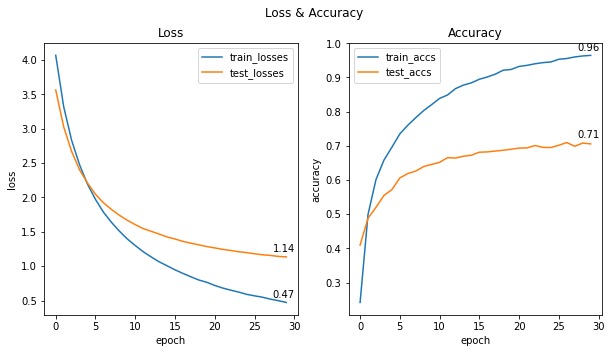

In [37]:
import matplotlib.pyplot as plt


# create data
x = np.arange(num_epoch)
train_losses, test_losses, train_accs, test_accs = history['train_losses'], history['test_losses'], history['train_accs'], history['test_accs']


# plt.figure(figsize=(100, 6), dpi=90)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Loss & Accuracy')

ax1.set_title('Loss')
ax1.plot(x, train_losses, label = "train_losses")
ax1.plot(x, test_losses, label = "test_losses")
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.set_title('Accuracy')
ax2.plot(x, train_accs, label = "train_accs")
ax2.plot(x, test_accs, label = "test_accs")
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')

for var in (train_accs, test_accs):
  ax2.annotate('%0.2f' % max(var), xy=(1, max(var)), xytext=(-25, 5), 
    xycoords=('axes fraction', 'data'), textcoords='offset points')
  
for var in (train_losses, test_losses):
  ax1.annotate('%0.2f' % min(var), xy=(1, min(var)), xytext=(-25, 5), 
    xycoords=('axes fraction', 'data'), textcoords='offset points')
    
  
ax1.legend()
ax2.legend()
plt.show()